## Import libraries

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf
import pathlib

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

## Get dataset

In [2]:
data_dir = pathlib.Path("/home/jovyan/work/LaptopVsPc")

## Analyse data

In [3]:
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

248


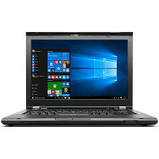

In [4]:
laptops = list(data_dir.glob('laptops/*'))
PIL.Image.open(str(laptops[5]))

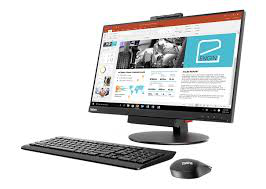

In [5]:
pc = list(data_dir.glob('pc/*'))
PIL.Image.open(str(pc[5]))

## Create dataset

In [6]:
train_image_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    brightness_range=(0.9, 1.1),
    horizontal_flip=True,
    vertical_flip=False
)

IMG_HEIGHT, IMG_WIDTH = 224, 224
batch_size = 32

train_data_gen = train_image_generator.flow_from_directory(batch_size=batch_size,
                                                           directory=data_dir,
                                                           shuffle=True,
                                                           target_size=(IMG_HEIGHT, IMG_WIDTH))
print(train_data_gen.class_indices)   


Found 248 images belonging to 2 classes.
{'laptops': 0, 'pc': 1}


## Look at generated samples

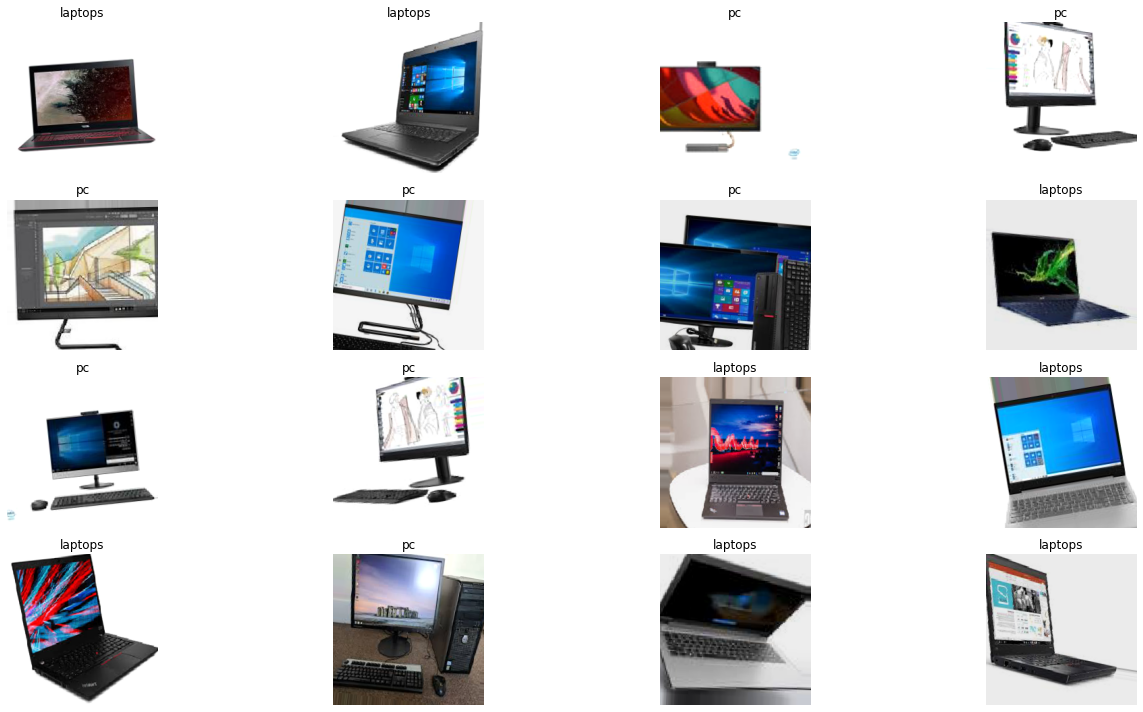

In [9]:
sample_training_images, labels = next(train_data_gen)
class_label = {v:k for k,v in train_data_gen.class_indices.items()}
fig, axes = plt.subplots(4, 4, figsize=(20,10))
axes = axes.flatten()
for img, label, ax in zip(sample_training_images, labels, axes):
    ax.set_title(class_label[np.argmax(label)])
    ax.imshow(img)
    ax.axis('off')
plt.tight_layout()